In [50]:
import pandas as pd
import numpy  as np
import sklearn as sk
import math as ma
import scipy.stats as st
import matplotlib
from matplotlib import pylab as plt
import textcleaner as tc 
import re
import nltk

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from os.path import dirname, abspath
d = dirname(dirname(abspath("data1030-student-f19/Whiskey1030/")))
nltk.download('wordnet')
  

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# load the data
df = pd.read_csv(dirname(d)+'/Data/whiskey_reviews.csv')
namesc = pd.read_csv(dirname(d)+"/Data/names.csv")

df.head()
#print(df.shape)

,ID,name,category,review.point,price,currency,description
0,1,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,$,"Magnificently powerful and intense. Caramels, ..."
1,2,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500,$,What impresses me most is how this whisky evol...
2,3,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,$,There have been some legendary Bowmores from t...
3,4,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,$,With a name inspired by a 1926 Buster Keaton m...
4,5,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,$,"Captivating, enticing, and wonderfully charmin..."


In [4]:
print(df.isnull().values.any()) #no missing values
print(df['currency'].value_counts()) # can drop currency

False
$    2247
Name: currency, dtype: int64


In [5]:
#drop currency and ID
df.drop(columns=['ID','currency'],inplace=True)
df.head()

,name,category,review.point,price,description
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ..."
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500,What impresses me most is how this whisky evol...
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,There have been some legendary Bowmores from t...
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin..."


In [6]:
# etraxct percents from name variable
percent=[re.findall(r"([0-9]+\.?[0-9]*)%",i) for i in df.name]
percent

percentll = [i[0] for i in [i or [0] for i in percent]]

#flat_list = [item for sublist in percent for item in sublist]
#len(flat_list)
percentll

df['percent'] = percentll
df['percent'] = df['percent'].astype(float)
df.head()

,name,category,review.point,price,description,percent
0,"Johnnie Walker Blue Label, 40%",Blended Scotch Whisky,97,225,"Magnificently powerful and intense. Caramels, ...",40.0
1,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500,What impresses me most is how this whisky evol...,40.5
2,"Bowmore 46 year old (distilled 1964), 42.9%",Single Malt Scotch,97,13500,There have been some legendary Bowmores from t...,42.9
3,"Compass Box The General, 53.4%",Blended Malt Scotch Whisky,96,325,With a name inspired by a 1926 Buster Keaton m...,53.4
4,"Chivas Regal Ultis, 40%",Blended Malt Scotch Whisky,96,160,"Captivating, enticing, and wonderfully charmin...",40.0


In [7]:
df[df.percent==0]
print(len(df[df.percent==0]))

16


In [8]:
# add missing percents
df.loc[df.name == 'Ardbeg An Oa','percent' ] = 46.6
df.loc[df.name == 'Balvenie 1973 Vintage, 30 year old, Cask #9219','percent' ] = 47.3
df.loc[df.name == 'Bowmore Oloroso Sherry Cask, 1964 Vintage','percent' ] = 42.9
df.loc[df.name == 'Scott','percent'] = 45
df.loc[df.name == 'Compass Box Hedonism Maximus','percent'] = 46
df.loc[df.name == 'Cadenhead','percent'] = 46
df.loc[df.name == 'Glenfarclas £511. 19s. 0d.','percent'] = 60

df.loc[668,'percent'] = 46
df.loc[909, 'percent']= 55
df.loc[984, 'percent'] = 43


df.loc[df.name == 'Ardmore Traditional Cask 1998','percent'] = 44.9

df.loc[1002, 'percent'] = 46
df.loc[1504, 'percent']= 46
df.loc[1647, 'percent']= 57.1
df.loc[1956, 'percent']= 40
df.loc[2034, 'percent']=53.5

In [9]:
# check balance of whiskey categories
print(df['category'].value_counts(normalize=True))

Single Malt Scotch            0.809524
Blended Scotch Whisky         0.093903
Blended Malt Scotch Whisky    0.058745
Single Grain Whisky           0.025367
Grain Scotch Whisky           0.012461
Name: category, dtype: float64


In [10]:
df['price'].describe()

count     2247
unique     453
top        100
freq        85
Name: price, dtype: object

In [16]:
df['price'] = df['price'].replace(['$15,000 or $60,000/set'], '15000')
df['price'] = df['price'].replace(['60000/set'], '60000')
df['price'] = df['price'].replace(['44/liter'], '44')

In [17]:
df['price']=df['price'].apply(lambda x:x.replace(',',''))
df['price']=df['price'].apply(lambda x:x.replace('.',''))

df['description']=df['description'].apply(lambda x:x.replace(',',''))
df['description']=df['description'].apply(lambda x:x.replace(')',''))
df['description']=df['description'].apply(lambda x:x.replace('(',''))
df['description']=df['description'].apply(lambda x:x.replace('.',''))
df['description']=df['description'].apply(lambda x:x.replace('!',''))
df['description']=df['description'].apply(lambda x:x.replace(':',''))
df['description']=df['description'].apply(lambda x:x.replace(';',''))
df['description']=df['description'].apply(lambda x:x.replace('-',''))
df['description']=df['description'].apply(lambda x:x.replace('—',''))

df['name']=df['name'].apply(lambda x:x.replace(')',''))
df['name']=df['name'].apply(lambda x:x.replace('(',''))
df['name']=df['name'].apply(lambda x:x.replace('!',''))
df['name']=df['name'].apply(lambda x:x.replace(':',''))
df['name']=df['name'].apply(lambda x:x.replace(';',''))


In [18]:
#Check stats of Price
df['price'] = df['price'].astype(float)
df['price'].describe()
#mean        709.205607
#std        5660.577607

count      2247.000000
mean        709.205607
std        5660.577607
min          12.000000
25%          70.000000
50%         110.000000
75%         200.000000
max      157000.000000
Name: price, dtype: float64

In [19]:
# Check Review Score Stats
df['review.point'].describe()
#mean       86.700045
#std         4.054055

count    2247.000000
mean       86.700045
std         4.054055
min        63.000000
25%        84.000000
50%        87.000000
75%        90.000000
max        97.000000
Name: review.point, dtype: float64

In [20]:
df['description']=df['description'].str.lower()
df['name']=df['name'].str.lower()

df.to_csv(dirname(d)+'/Data/dfmodel.csv', encoding='utf-8', index=False)
df.head()

,name,category,review.point,price,description,percent
0,"johnnie walker blue label, 40%",Blended Scotch Whisky,97,225.0,magnificently powerful and intense caramels dr...,40.0
1,"black bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,what impresses me most is how this whisky evol...,40.5
2,"bowmore 46 year old distilled 1964, 42.9%",Single Malt Scotch,97,13500.0,there have been some legendary bowmores from t...,42.9
3,"compass box the general, 53.4%",Blended Malt Scotch Whisky,96,325.0,with a name inspired by a 1926 buster keaton m...,53.4
4,"chivas regal ultis, 40%",Blended Malt Scotch Whisky,96,160.0,captivating enticing and wonderfully charming ...,40.0


In [21]:
#ONE HOT ENCODE WHISKEY TYPES
hotenc=OneHotEncoder(sparse=False)

df['category'].unique()

df_cat=hotenc.fit_transform(df[['category']])
hotenc.get_feature_names()

df_cat= pd.DataFrame(df_cat)
df_cat.columns = hotenc.get_feature_names()

df_cat.head()

,x0_Blended Malt Scotch Whisky,x0_Blended Scotch Whisky,x0_Grain Scotch Whisky,x0_Single Grain Whisky,x0_Single Malt Scotch
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0


In [22]:
#create new dataset with preprocessing and hot encoding
dfpre=df.copy()
dfpre.head()

,name,category,review.point,price,description,percent
0,"johnnie walker blue label, 40%",Blended Scotch Whisky,97,225.0,magnificently powerful and intense caramels dr...,40.0
1,"black bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,what impresses me most is how this whisky evol...,40.5
2,"bowmore 46 year old distilled 1964, 42.9%",Single Malt Scotch,97,13500.0,there have been some legendary bowmores from t...,42.9
3,"compass box the general, 53.4%",Blended Malt Scotch Whisky,96,325.0,with a name inspired by a 1926 buster keaton m...,53.4
4,"chivas regal ultis, 40%",Blended Malt Scotch Whisky,96,160.0,captivating enticing and wonderfully charming ...,40.0


In [23]:
# drop category and concatenate one hot encoded variables
dfpre.drop(['category'],axis=1, inplace=True)
dfpre=pd.concat([dfpre,df_cat],axis=1)

In [24]:
dfpre.head()

,name,review.point,price,description,percent,x0_Blended Malt Scotch Whisky,x0_Blended Scotch Whisky,x0_Grain Scotch Whisky,x0_Single Grain Whisky,x0_Single Malt Scotch
0,"johnnie walker blue label, 40%",97,225.0,magnificently powerful and intense caramels dr...,40.0,0.0,1.0,0.0,0.0,0.0
1,"black bowmore, 1964 vintage, 42 year old, 40.5%",97,4500.0,what impresses me most is how this whisky evol...,40.5,0.0,0.0,0.0,0.0,1.0
2,"bowmore 46 year old distilled 1964, 42.9%",97,13500.0,there have been some legendary bowmores from t...,42.9,0.0,0.0,0.0,0.0,1.0
3,"compass box the general, 53.4%",96,325.0,with a name inspired by a 1926 buster keaton m...,53.4,1.0,0.0,0.0,0.0,0.0
4,"chivas regal ultis, 40%",96,160.0,captivating enticing and wonderfully charming ...,40.0,1.0,0.0,0.0,0.0,0.0


In [25]:
sscaler = StandardScaler()
mmscaler = MinMaxScaler()

In [26]:
#transform dfpre dataset
dfpre[['review.point']]=mmscaler.fit_transform(dfpre[['review.point']])
dfpre[['percent']]=sscaler.fit_transform(dfpre[['percent']])
dfpre[['price']]=sscaler.fit_transform(dfpre[['price']])

In [27]:
# make sure all words are lowercase
dfpre['description']=dfpre['description'].str.lower()
dfpre['name']=dfpre['name'].str.lower()

dfpre.to_csv(dirname(d)+'/Data/dfpre.csv', encoding='utf-8', index=False)
dfpre.head()

,name,review.point,price,description,percent,x0_Blended Malt Scotch Whisky,x0_Blended Scotch Whisky,x0_Grain Scotch Whisky,x0_Single Grain Whisky,x0_Single Malt Scotch
0,"johnnie walker blue label, 40%",1.000000,-0.085559,magnificently powerful and intense caramels dr...,-1.276825,0.0,1.0,0.0,0.0,0.0
1,"black bowmore, 1964 vintage, 42 year old, 40.5%",1.000000,0.669832,what impresses me most is how this whisky evol...,-1.196793,0.0,0.0,0.0,0.0,1.0
2,"bowmore 46 year old distilled 1964, 42.9%",1.000000,2.260130,there have been some legendary bowmores from t...,-0.812641,0.0,0.0,0.0,0.0,1.0
3,"compass box the general, 53.4%",0.970588,-0.067889,with a name inspired by a 1926 buster keaton m...,0.868027,1.0,0.0,0.0,0.0,0.0
4,"chivas regal ultis, 40%",0.970588,-0.097044,captivating enticing and wonderfully charming ...,-1.276825,1.0,0.0,0.0,0.0,0.0


In [28]:
# extract descriptions by whiskey type
blended_malt_scotch=dfpre.loc[dfpre["x0_Blended Malt Scotch Whisky"] == 1, ['description']]
blended_scotch=dfpre.loc[dfpre["x0_Blended Scotch Whisky"] == 1, ['description']]
grain_scotch_=dfpre.loc[dfpre["x0_Grain Scotch Whisky"] == 1, ['description']]
single_grain_whisky=dfpre.loc[dfpre["x0_Single Grain Whisky"] == 1, ['description']]
single_malt_scotch=dfpre.loc[dfpre["x0_Single Malt Scotch"] == 1, ['description']]


In [28]:
# convert dataframe column to a list
#descriptions=df["description"].tolist()
names=dfpre["name"].tolist()

# lematize words, remove stopwords and numbers
#dclean=tc.document(descriptions).remove_stpwrds()
#dclean=tc.document(dclean).lemming()
#dclean=tc.document(dclean).remove_numbers()

In [174]:
nclean=tc.document(names).remove_stpwrds()

In [152]:
# dclean=tc.document(descriptions).remove_stpwrds()
# dclean=tc.document(dclean).lemming()
# dclean=tc.document(dclean).remove_numbers()

In [82]:
# # BLENDED MALT SCOTCH convert dataframesinto a list
# cat1=blended_malt_scotch["description"].tolist()
# cat1=tc.document(cat1).remove_stpwrds()
# cat1=tc.document(cat1).lemming()
# cat1=tc.document(cat1).remove_numbers()

# #BLENDED SCOTCH convert dataframesinto a list
# cat2=blended_scotch["description"].tolist()
# cat2=tc.document(cat2).remove_stpwrds()
# cat2=tc.document(cat2).lemming()
# cat2=tc.document(cat2).remove_numbers()

# #GRAIN SCOTCH convert dataframesinto a list
# cat3=grain_scotch_["description"].tolist()
# cat3=tc.document(cat3).remove_stpwrds()
# cat3=tc.document(cat3).lemming()
# cat3=tc.document(cat3).remove_numbers()

# #single_grain_whisky convert dataframesinto a list
# cat4=single_grain_whisky["description"].tolist()
# cat4=tc.document(cat4).remove_stpwrds()
# cat4=tc.document(cat4).lemming()
# cat4=tc.document(cat4).remove_numbers()

# #single_malt_scotch convert dataframesinto a list
# cat5=single_malt_scotch["description"].tolist()
# cat5=tc.document(cat5).remove_stpwrds()
# cat5=tc.document(cat5).lemming()
# cat5=tc.document(cat5).remove_numbers()

In [83]:
# create a dataframe from a word matrix
# def wm2df(wm, feat_names):
    
#     # create an index for each row
#     doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
#     df = pd.DataFrame(data=wm.toarray(), index=doc_names,
#                       columns=feat_names)
#     return(df)

In [180]:
# namesc.head()
# namesc.to_csv(dirname(d)+'/Data/names.csv', encoding='utf-8', index=False)

In [84]:
# # instantiate the vectorizer object
# cvec = CountVectorizer(lowercase=False)

# # convert the documents into a document-term matrix
# wm = cvec.fit_transform()

# # retrieve the terms found in the corpora
# tokens = cvec.get_feature_names()

# # create a dataframe from the matrix
# cat5=wm2df(wm, tokens)

# # save datafram
# cat5.to_csv(dirname(d)+'/Data/cat5.csv', encoding='utf-8', index=False)
# ddclean.drop(columns=['whisky'],inplace=True)

In [29]:
namesc.head()

,00,002,0074,0080,01,04,05,0544,06,07,...,xtra,xx,xxv,xxviii,year,years,york,young,zest,ìle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
nbrand=list(namesc.columns)

In [32]:
dmarge=['Walker','Chivas','Glenfiddich','Talisker','Glenmorangie','Lagavulin',"Glenkinchie","Dimple","Monkey", "Ballantine’s","Grant’s","Dewar’s","Douglas",
        "Laphroaig","Auchentoshan","Beam","Daniels","Makers", "Woodford","Hudson","Bulleit","Cougar","Blanton’s","Dickel","Street","Turkey","Eagle","Bushmills",
        "Jameson","Dew","Dubliner","Glendalough","Tears","Teeling","Midleton","Irishman","Kilbeggan","Kakubin","Yamakazi","Hakushu","Hibiki","Nikka","Ichiro’s", 
        "Club", "Royal","Fireball", "Crossing","Whistlepig","Cove","Starward","Hellyers",  "Hill","Lark","Smith’s"]

dmarge=[x.lower() for x in dmarge]
#removed Royal because it appeared twice
#royal is part of a larger group
#https://www.dmarge.com/2019/02/whiskey-brands.html

In [33]:
print(len(dmarge))
dmargv=list(set(nbrand).intersection(dmarge))
print(len(dmargv))

54
15


In [34]:
mj=["Monkey", "Bushmills","Hudson","WhistlePig","Compass","Buffalo", "Maker's","Glendronach","Tullamore", "Dickel", "Superior", 
       "Rittenhouse", "Balvenie","Elijah", "Highland", "Redbreast","Blanton's", "Grouse","Bulleit","Jameson","Aberfeldy", "Michter's","Yamazaki", "Corn", 
       "Lot","Glenrothes","Roses", "Beam","Ghaelach","Booker's","Lagavulin","Redemption","Craigellachie","Spot","Bowmore","Willett","Hibiki","Macallan","Crown", "Knappogue",
       "Watershed",'Forester', "Tears","Knob","Jefferson’s","Glenmorangie","Lock", "Few","Laphroaig",]

mj=[x.lower() for x in mj]
#removed Mcallan and Balvanie because two whiskeys from each brand appeared twice in the set
#https://www.mensjournal.com/food-drink/the-50-best-whiskeys-in-the-world-w211382/monkey-shoulder-blended-malt-scotch-w211406/

In [35]:
print(len(mj))
mjv=list(set(nbrand).intersection(mj))
print(len((mjv)))

49
15


In [36]:
total_n=mjv+dmargv
len(total_n)

30

In [37]:
print(len(dmargv))
print(len(mjv))
total_brands=set(total_n)
print(len(total_brands))
total_b=list(total_brands)
print(total_b)

15
15
27
['auchentoshan', 'grouse', 'laphroaig', 'cove', 'street', 'crown', 'club', 'glendronach', 'bowmore', 'glenkinchie', 'glenrothes', 'glenfiddich', 'walker', 'macallan', 'aberfeldy', 'craigellachie', 'chivas', 'eagle', 'royal', 'highland', 'few', 'douglas', 'glenmorangie', 'talisker', 'compass', 'lagavulin', 'balvenie']


In [38]:
namesc.head()

,00,002,0074,0080,01,04,05,0544,06,07,...,xtra,xx,xxv,xxviii,year,years,york,young,zest,ìle
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
new_names=namesc[total_b]
print(new_names.shape)
new_names.head(2)

(2247, 27)


,auchentoshan,grouse,laphroaig,cove,street,crown,club,glendronach,bowmore,glenkinchie,...,eagle,royal,highland,few,douglas,glenmorangie,talisker,compass,lagavulin,balvenie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
#MAJOR TEXT CLEANING - Making sure that for the sum across all columns, the total sum is 1 (since we are trying to distinguish between brands, cannot have 1s in multiple columns)

print (new_names.loc[new_names['chivas']==2].index)
#Chivas Regal The Chivas Brothers' Blend 12 year old, 40% is the name of the observation - will change chivas to 1
new_names.at[1195, 'chivas'] = 1
#chivas regal has a max of 2

#print(new_names.loc[237])
#print(df.loc[237])
#reduce royal to 0 in new_names
new_names.at[237, 'royal'] = 0

#print(new_names.loc[540]) # and 541
#print(df.loc[540])
#whiskey is distilled at Glenrothes, brand is douglas laing - remove Glenrothes for obs 540 and 541
#reduce royal to 0 in new_names
new_names.at[540, 'glenrothes'] = 0
new_names.at[541, 'glenrothes'] = 0

# print(new_names.loc[737]) #and 873, 1381
# print(df.loc[737])
#whiskey is distilled at laphroaig, brand is douglas laing
new_names.at[737, 'laphroaig'] = 0
new_names.at[873, 'laphroaig'] = 0
new_names.at[1381, 'laphroaig'] = 0

# print(new_names.loc[1207])
# print(df.loc[1207])
# whiskey is distilled at auchentoshan but brand is douglas laing
new_names.at[1207, 'auchentoshan'] = 0

# print(new_names.loc[1313])
# print(df.loc[1313])
# whiskey is douglas laing contains word royal
new_names.at[1313, 'royal'] = 0

# print(new_names.loc[1380]) #and 1383, 1503, 1689
# print(df.loc[1380]) 
# whiskey is douglas laing distilled at highland
new_names.at[1380, 'highland'] = 0
new_names.at[1383, 'highland'] = 0
new_names.at[1503, 'highland'] = 0
new_names.at[1689, 'highland'] = 0

# print(new_names.loc[1415])
# print(df.loc[1415])
# brand is Jhonnie Walker, contains word royal
new_names.at[1415, 'royal'] = 0

# print(new_names.loc[1901]) #and 2026
# print(df.loc[1901])
# whiskey is douglas laing distilled at bowemore
new_names.at[1901, 'bowmore'] = 0 
new_names.at[2026, 'bowmore'] = 0 

# print(new_names.loc[2004])
# print(df.loc[2004])
# whiskey is douglas laing distilled at mcallan
new_names.at[2004, 'macallan'] = 0

# print(new_names.loc[2133]) # and 2135, 2157
# print(df.loc[2133])
# whiskey is douglas laing distilled at talisker
new_names.at[2133, 'talisker'] = 0
new_names.at[2134, 'talisker'] = 0
new_names.at[2157, 'talisker'] = 0

# print(new_names.loc[169]) # and 280, 771, 975, 1412
# print(df.loc[169])
# whiskey is compass box drop street
new_names.at[169, 'street'] = 0
new_names.at[280, 'street'] = 0
new_names.at[771, 'street'] = 0
new_names.at[975, 'street'] = 0
new_names.at[1412, 'street'] = 0
# new_names.at[2134, 'talisker'] = 0
# new_names.at[2157, 'talisker'] = 0

# print(new_names.loc[1415]) # and 1785
# print(df.loc[1415])
# whiskey is jhonnie Walker drop club
new_names.at[1415, 'club'] = 0
new_names.at[1785, 'club'] = 0

# print(new_names.loc[1741])
# print(df.loc[1741])
#whiskey is talisker drop craigellachi
new_names.at[1741, 'craigellachie'] = 0

# print(new_names.loc[1751])
# print(df.loc[1751])
#whiskey is douglas laing distilled at craigellachie
new_names.at[1751, 'craigellachie'] = 0

Int64Index([1195], dtype='int64')


In [41]:
new_names.describe()

,auchentoshan,grouse,laphroaig,cove,street,crown,club,glendronach,bowmore,glenkinchie,...,eagle,royal,highland,few,douglas,glenmorangie,talisker,compass,lagavulin,balvenie
count,2247.000000,2247.000000,2247.000000,2247.000000,2247.0,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,...,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000,2247.000000
mean,0.017356,0.004895,0.012906,0.001335,0.0,0.001335,0.000445,0.011126,0.025367,0.003560,...,0.000445,0.009791,0.032933,0.000445,0.036493,0.015131,0.010681,0.019137,0.012461,0.016466
std,0.130625,0.069811,0.112895,0.036523,0.0,0.036523,0.021096,0.104915,0.157273,0.059575,...,0.021096,0.098485,0.178500,0.021096,0.187555,0.122102,0.102818,0.137036,0.110956,0.127289
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [42]:
print(list(new_names.columns))

['auchentoshan', 'grouse', 'laphroaig', 'cove', 'street', 'crown', 'club', 'glendronach', 'bowmore', 'glenkinchie', 'glenrothes', 'glenfiddich', 'walker', 'macallan', 'aberfeldy', 'craigellachie', 'chivas', 'eagle', 'royal', 'highland', 'few', 'douglas', 'glenmorangie', 'talisker', 'compass', 'lagavulin', 'balvenie']


In [43]:
#sum new brands to see repeats of keyword brands in columns
new_names['sum']= (new_names['lagavulin'] + new_names['walker'] + new_names['aberfeldy'] + new_names['bowmore'] + new_names['compass'] + new_names['highland'] + new_names['glenrothes'] +
                    new_names['auchentoshan'] + new_names['laphroaig'] + new_names['macallan'] + new_names['balvenie'] + new_names['douglas'] + new_names['glendronach'] +
                    new_names['chivas'] + new_names['talisker'] + new_names['glenmorangie'] + new_names['royal'] + new_names['grouse'] + new_names['craigellachie'] + 
                    new_names['glenkinchie'] + new_names['street'] + new_names['club'] + new_names['cove'] + new_names['crown'] + new_names['eagle'] + new_names['few'])

new_names.describe()
#brand has a value of 2
print (new_names.loc[new_names['sum']==2].index)

Int64Index([], dtype='int64')


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [44]:
#check sum and
brand_freq=new_names.sum(axis = 0, skipna = True)
type(brand_freq)
brand = pd.DataFrame([brand_freq])
brandT= brand.transpose()
brandT= brandT.sort_values(0,ascending=False)
brandT
#cut at 11 and above because for Grousse after checking through the dataset, there were different brands.b
# need to convert brand into a category by renaming 0 - 12 values

,0
sum,679
douglas,82
highland,74
bowmore,57
macallan,53
glenrothes,45
compass,43
auchentoshan,39
balvenie,37
glenmorangie,34


In [45]:
new_names.drop([col for col, val in new_names.sum().iteritems() if val < 12], axis=1, inplace=True)
print(new_names.columns)

Index(['auchentoshan', 'laphroaig', 'glendronach', 'bowmore', 'glenrothes',
       'glenfiddich', 'walker', 'macallan', 'aberfeldy', 'chivas', 'royal',
       'highland', 'douglas', 'glenmorangie', 'talisker', 'compass',
       'lagavulin', 'balvenie', 'sum'],
      dtype='object')


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [46]:
new_names.drop(columns=['sum'], inplace=True)
new_names.head()
#print(len(new_names.columns))

,auchentoshan,laphroaig,glendronach,bowmore,glenrothes,glenfiddich,walker,macallan,aberfeldy,chivas,royal,highland,douglas,glenmorangie,talisker,compass,lagavulin,balvenie
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [47]:
#change values of variables and sum them to create new categorical variable
new_names['lagavulin'].replace([0,1],[0,2],inplace=True)
new_names['walker'].replace([0,1],[0,3],inplace=True)
new_names['aberfeldy'].replace([0,1],[0,4],inplace=True)
new_names['bowmore'].replace([0,1],[0,5],inplace=True)
new_names['compass'].replace([0,1],[0,6],inplace=True)
new_names['highland'].replace([0,1],[0,7],inplace=True)
new_names['glenrothes'].replace([0,1],[0,8],inplace=True)
new_names['auchentoshan'].replace([0,1],[0,9],inplace=True)
new_names['laphroaig'].replace([0,1],[0,10],inplace=True)
new_names['macallan'].replace([0,1],[0,11],inplace=True)
new_names['balvenie'].replace([0,1],[0,12],inplace=True)
new_names['douglas'].replace([0,1],[0,13],inplace=True)
new_names['glendronach'].replace([0,1],[0,14],inplace=True)
new_names['chivas'].replace([0,1],[0,15],inplace=True)
new_names['talisker'].replace([0,1],[0,16],inplace=True)
new_names['glenmorangie'].replace([0,1],[0,17],inplace=True)
new_names['royal'].replace([0,1],[0,18],inplace=True)
#glenfiddich has a value of 1

new_names['brand']= (new_names['lagavulin'] + new_names['walker'] + new_names['aberfeldy'] + new_names['bowmore'] + new_names['compass'] + new_names['highland']
                     + new_names['glenrothes'] + new_names['auchentoshan'] + new_names['laphroaig'] + new_names['macallan'] + new_names['balvenie'] + new_names['douglas']
                     + new_names['glendronach'] + new_names['chivas'] + new_names['talisker'] + new_names['glenmorangie'] + new_names['royal'] + new_names['glenfiddich'])

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:6788: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
new_names['brand'].value_counts()

0     1584
13      82
7       74
5       57
11      53
8       45
6       43
9       39
12      37
17      34
10      29
2       28
3       27
14      25
16      24
18      22
1       19
4       13
15      12
Name: brand, dtype: int64

In [49]:
#change names of numbers to whiskey brand
new_names['brand'].replace([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18],['noinf','glenfiddich','lagavulin','walker','aberfeldy','bowmore','compass','highland','glenrothes',
                                                                    'auchentoshan','laphroaig','macallan','balvenie','douglas','glendronach','chivas','talisker',
                                                                     'glenmorangie','royal'],inplace=True)
new_names['brand'].value_counts()
new_names.to_csv(dirname(d)+'/Data/names50.csv', encoding='utf-8', index=False)

In [85]:
# load the data
#ddclean = pd.read_csv(dirname(d)+'/Data/ddclean.csv')

cat1 = pd.read_csv(dirname(d)+'/Data/cat1.csv')
cat2 = pd.read_csv(dirname(d)+'/Data/cat2.csv')
cat3 = pd.read_csv(dirname(d)+'/Data/cat3.csv')
cat4 = pd.read_csv(dirname(d)+'/Data/cat4.csv')
cat5 = pd.read_csv(dirname(d)+'/Data/cat5.csv')
ddclean = pd.read_csv(dirname(d)+'/Data/ddclean.csv')

ddclean.head()
#2247 rows × 8646 columns

,abandon,abandoned,abc,abdomen,aberdeenshire,aberfeldy,aberlour,abhainn,abiding,ability,...,zestyzingy,zigzag,zinfandel,zing,zinginess,zinging,zingy,zippy,zone,ìle
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [86]:
ddclean.shape

(2247, 8645)

compute number of words and average size of the word (total number of characters/number of words), if numbers in description

In [121]:
word_freq=ddclean.sum(axis = 0, skipna = True)
type(word_freq)

o_word = pd.DataFrame([word_freq])
o_word=o_word.transpose()
o_word = o_word.sort_values(0,ascending=False)

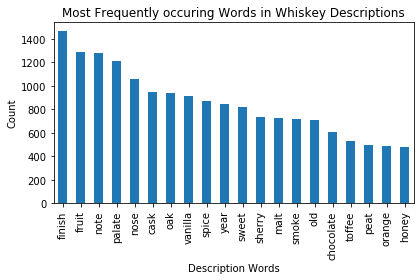

In [122]:
#word_freq.value_counts()[:20].plot(kind='bar')
o_word[0][:20].plot.bar()
plt.xlabel('Description Words')
plt.ylabel('Count')
plt.title('Most Frequently occuring Words in Whiskey Descriptions')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/word_freq.png',dpi=300)
plt.show()

In [89]:
#Blended Malt Scotch Whisky
c1word_freq=cat1.sum(axis = 0, skipna = True)
c1_word = pd.DataFrame([c1word_freq])
c1_word=c1_word.transpose()
c1_word = c1_word.sort_values(0,ascending=False)
c1_word.head()

,0
malt,81
finish,64
smoke,63
fruit,63
spice,56


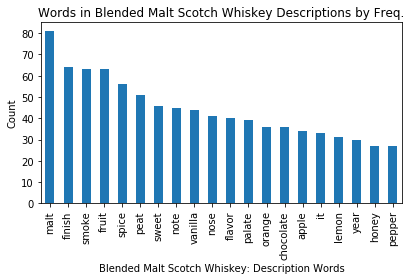

In [90]:
#word_freq.value_counts()[:20].plot(kind='bar')
c1_word[0][:20].plot.bar()
plt.xlabel('Blended Malt Scotch Whiskey: Description Words')
plt.ylabel('Count')
plt.title('Words in Blended Malt Scotch Whiskey Descriptions by Freq.')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/c1word_freq.png',dpi=300)
plt.show()

In [91]:
c2word_freq=cat2.sum(axis = 0, skipna = True)
c2_word = pd.DataFrame([c2word_freq])
c2_word=c2_word.transpose()
c2_word = c2_word.sort_values(0,ascending=False)
c2_word.head()

,0
spice,152
finish,132
blend,113
fruit,101
note,96


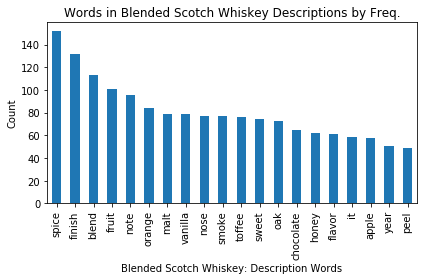

In [92]:
#word_freq.value_counts()[:20].plot(kind='bar')
c2_word[0][:20].plot.bar()
plt.xlabel('Blended Scotch Whiskey: Description Words')
plt.ylabel('Count')
plt.title('Words in Blended Scotch Whiskey Descriptions by Freq.')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/c2word_freq.png',dpi=300)
plt.show()

In [93]:
c3word_freq=cat3.sum(axis = 0, skipna = True)
c3_word = pd.DataFrame([c3word_freq])
c3_word=c3_word.transpose()
c3_word = c3_word.sort_values(0,ascending=False)
c3_word.head()

,0
grain,30
note,24
finish,20
vanilla,19
spice,18


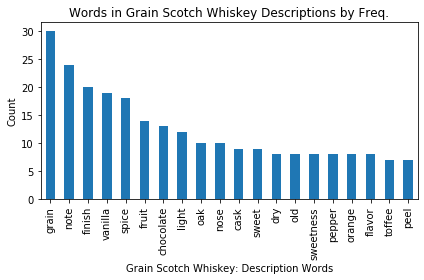

In [94]:
#word_freq.value_counts()[:20].plot(kind='bar')
c3_word[0][:20].plot.bar()
plt.xlabel('Grain Scotch Whiskey: Description Words')
plt.ylabel('Count')
plt.title('Words in Grain Scotch Whiskey Descriptions by Freq.')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/c3word_freq.png',dpi=300)
plt.show()

In [95]:
c4word_freq=cat4.sum(axis = 0, skipna = True)
c4_word = pd.DataFrame([c4word_freq])
c4_word=c4_word.transpose()
c4_word = c4_word.sort_values(0,ascending=False)
c4_word.head()

,0
finish,45
grain,37
bottle,36
vanilla,36
spice,33


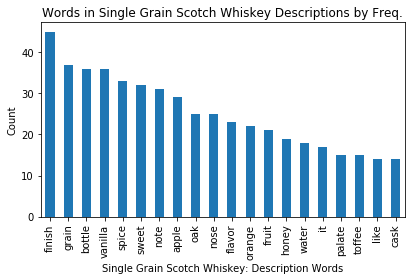

In [96]:
#word_freq.value_counts()[:20].plot(kind='bar')
c4_word[0][:20].plot.bar()
plt.xlabel('Single Grain Scotch Whiskey: Description Words')
plt.ylabel('Count')
plt.title('Words in Single Grain Scotch Whiskey Descriptions by Freq.')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/c4word_freq.png',dpi=300)
plt.show()

In [97]:
c5word_freq=cat5.sum(axis = 0, skipna = True)
c5_word = pd.DataFrame([c5word_freq])
c5_word=c5_word.transpose()
c5_word = c5_word.sort_values(0,ascending=False)
c5_word.head()

,0
finish,1206
palate,1113
fruit,1087
note,1086
nose,905


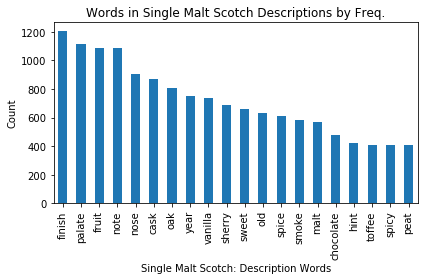

In [98]:
#word_freq.value_counts()[:20].plot(kind='bar')
c5_word[0][:20].plot.bar()
plt.xlabel('Single Malt Scotch: Description Words')
plt.ylabel('Count')
plt.title('Words in Single Malt Scotch Descriptions by Freq.')
plt.tight_layout()

plt.savefig(dirname(d)+'/Figures/c5word_freq.png',dpi=300)
plt.show()

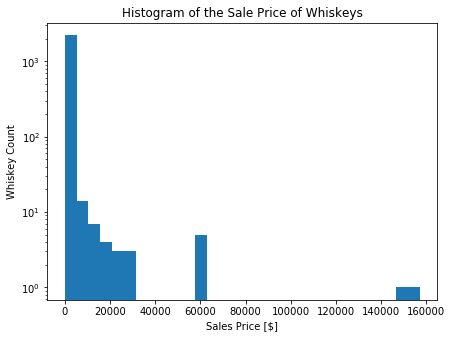

In [99]:
# Check histogram for Price
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
#plt.hist(y,bins=30,log=True)
df['price'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Sales Price [$]')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Sale Price of Whiskeys')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/price_hist.png',dpi=300)
plt.show()

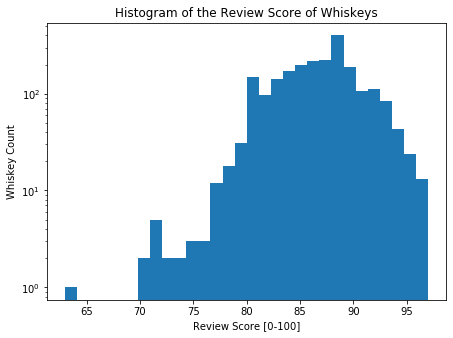

In [100]:
# Check histogram for Review Score
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
df['review.point'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Review Score [0-100]')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Review Score of Whiskeys')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/review_hist.png',dpi=300)
plt.show()

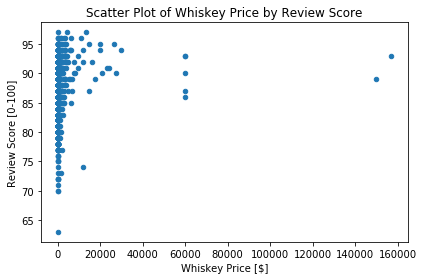

In [101]:
df.plot.scatter('price','review.point') # the color and size of each point can also be defined

plt.xlabel('Whiskey Price [$]')
plt.ylabel('Review Score [0-100]')
plt.title('Scatter Plot of Whiskey Price by Review Score')
#plt.tight_layout()
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/scatter_review_price.png',dpi=300)
plt.show()


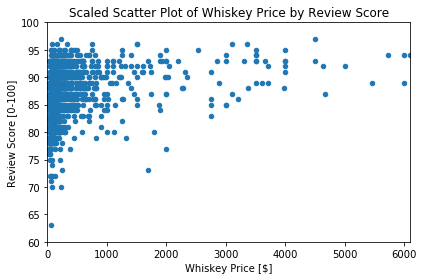

In [102]:
df.plot.scatter('price','review.point') # the color and size of each point can also be defined

plt.xlabel('Whiskey Price [$]')
plt.ylabel('Review Score [0-100]')
plt.title('Scaled Scatter Plot of Whiskey Price by Review Score')

plt.xlim(0,6100)
plt.ylim(60,100)
#plt.tight_layout()
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/scaled_scatter_review_price.png',dpi=900)
plt.show()

<Figure size 748.8x489.6 with 0 Axes>

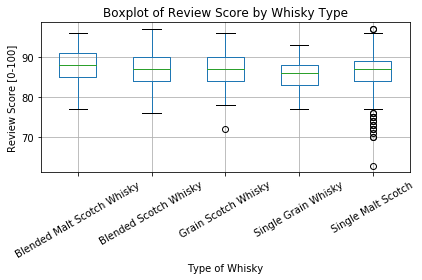

In [103]:
plt.figure(figsize=(10.4,6.8))
df[['review.point','category']].boxplot(by='category')

plt.suptitle('')
plt.title('Boxplot of Review Score by Whisky Type')
plt.ylabel('Review Score [0-100]')
plt.xlabel('Type of Whisky')
plt.xticks(rotation= 30)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/score_type_boxplot.png',dpi=900)
plt.show()

<Figure size 748.8x489.6 with 0 Axes>

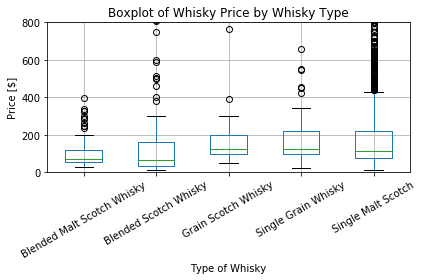

In [104]:
plt.figure(figsize=(10.4,6.8))
df[['price','category']].boxplot(by='category')
plt.suptitle('')
plt.title('Boxplot of Whisky Price by Whisky Type')
plt.ylabel('Price [$]')
plt.xlabel('Type of Whisky')
plt.ylim(0,800)
plt.xticks(rotation= 30)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/price_type_boxplot.png',dpi=900)
plt.show()

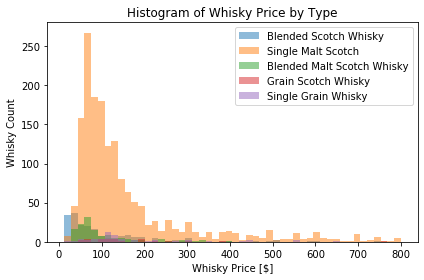

In [105]:
categories = df['category'].unique()
bin_range = (df['price'].min(),800)

for c in categories:
    plt.hist(df[df['category']==c]['price'],alpha=0.5,label=c,range=bin_range,bins=50)
plt.legend()
plt.ylabel('Whisky Count')
plt.xlabel('Whisky Price [$]')
plt.title('Histogram of Whisky Price by Type')
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/cunm_hist.png',dpi=900)
plt.show()



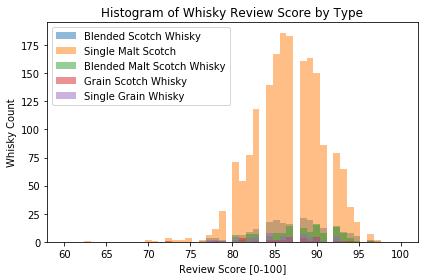

In [106]:
categories = df['category'].unique()
bin_range = (60,100)

for c in categories:
    plt.hist(df[df['category']==c]['review.point'],alpha=0.5,label=c,range=bin_range,bins=50)
plt.legend()
plt.ylabel('Whisky Count')
plt.xlabel('Review Score [0-100]')
plt.title('Histogram of Whisky Review Score by Type')
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/cum_rev_hist.png',dpi=900)
plt.show()


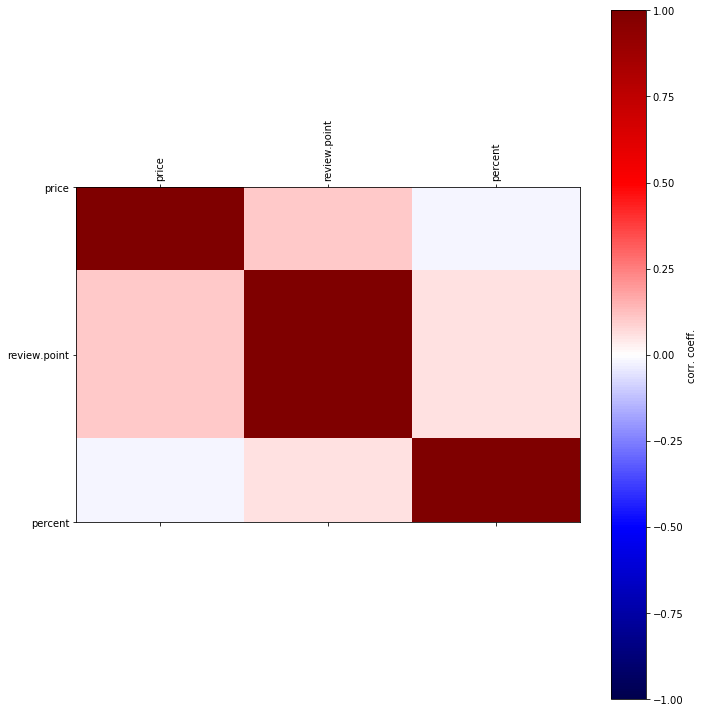

In [107]:
corrmat = df.corr()

all_cols = corrmat.sort_values('price',ascending=False)['price'].index 
cols = all_cols[:10] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.savefig(dirname(d)+'/Figures/correlation.png',dpi=300)
plt.tight_layout()
plt.show()

In [108]:
#try to find words that are tfd and idf afor each specific whiskey type
# interesting ratio for NLP
#percentage of word type by whiskey dividied by other whiskey and do it
#cluster by whiskey type
# sentiment analysis
# doing correlations and TDF and IDF

# make itb for list 
# make pandas series (filter)
#write a function that loops through all the names - 4 digit number if probably the year
#year old 2 digit number
#take the number right before the percent sign
# lookup function in python
# pattern matching python
# scatter plot review score an

## Was going to also extract the year from the whiskey, but the age is inconsistent and many are missing --> next steps

In [109]:
# extract length of description and length of name
dfmodel = pd.read_csv(dirname(d)+'/Data/dfmodel.csv')

dfmodel.rename(columns={"price": "Wprice"},inplace=True)
dfmodel.head()

lengthd = [len(re.findall('\w+([-]\w+)*', i)) for i in dfmodel.description]
dfmodel['d_len']=lengthd
dfmodel['d_len'] = dfmodel['d_len'].astype(float)


lengthn = [len(re.findall('\w+([-]\w+)*', i)) for i in dfmodel.name]
dfmodel['n_len']=lengthn
dfmodel['n_len'] = dfmodel['n_len'].astype(float)

# extract number of characters in the description and name of a whiskey

dfmodel['d_charw'] = (dfmodel['description'].str.len())/dfmodel['d_len']
dfmodel['n_charw'] = (dfmodel['name'].str.len())/dfmodel['n_len']

dfmodel.rename(columns={"price": "Wprice"},inplace=True)

dfmodel.to_csv(dirname(d)+'/Data/dfmodel_nvars.csv', encoding='utf-8', index=False)
dfmodel.head()

,name,category,review.point,Wprice,description,percent,d_len,n_len,d_charw,n_charw
0,"johnnie walker blue label, 40%",Blended Scotch Whisky,97,225.0,magnificently powerful and intense caramels dr...,40.0,67.0,5.0,6.537313,6.000000
1,"black bowmore, 1964 vintage, 42 year old, 40.5%",Single Malt Scotch,97,4500.0,what impresses me most is how this whisky evol...,40.5,83.0,9.0,5.674699,5.222222
2,"bowmore 46 year old distilled 1964, 42.9%",Single Malt Scotch,97,13500.0,there have been some legendary bowmores from t...,42.9,86.0,8.0,5.593023,5.125000
3,"compass box the general, 53.4%",Blended Malt Scotch Whisky,96,325.0,with a name inspired by a 1926 buster keaton m...,53.4,79.0,6.0,5.367089,5.000000
4,"chivas regal ultis, 40%",Blended Malt Scotch Whisky,96,160.0,captivating enticing and wonderfully charming ...,40.0,73.0,4.0,6.849315,5.750000


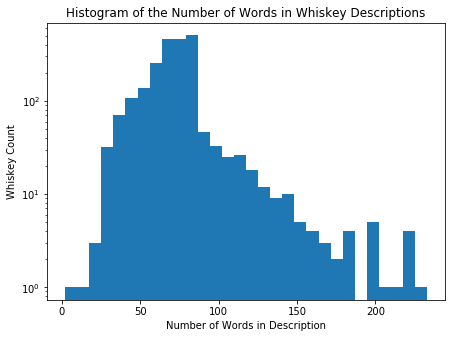

In [110]:
# HISTOGRAM DESCRIPTION LENGTH
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['d_len'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Number of Words in Description')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Number of Words in Whiskey Descriptions')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/desc_len_hist.png',dpi=300)
plt.show()

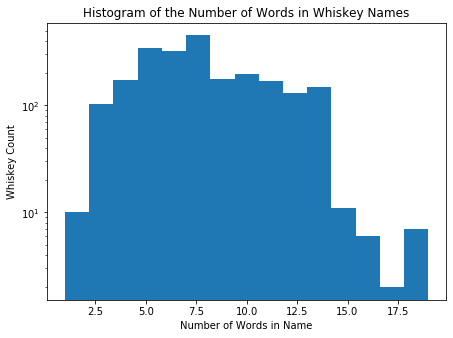

In [111]:
# HISTOGRAM: NAME LENGTH
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['n_len'].hist(bins=15,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Number of Words in Name')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Number of Words in Whiskey Names')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/name_len_hist.png',dpi=300)
plt.show()

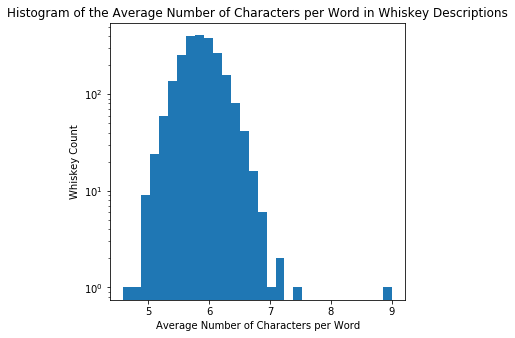

In [112]:
# HISTOGRAM OF AVERAGE NUMBER OF CHARACTERS PER WORD DESCRIPTION
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['d_charw'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Average Number of Characters per Word')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Average Number of Characters per Word in Whiskey Descriptions')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/desc_char_hist.png',dpi=300)
plt.show()

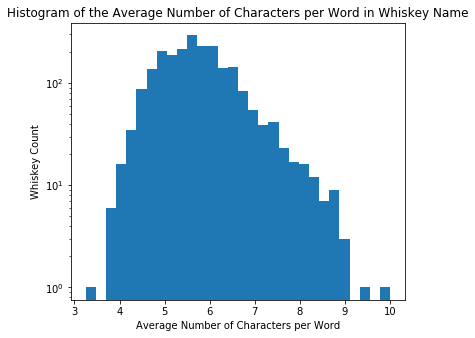

In [113]:
# HISTOGRAM OF AVERAGE NUMBER OF CHARACTERS PER WORD NAME
# define your canvas, e.g., figure size, number of subplots and their positions, etc
plt.figure(figsize=(6.4,4.8))

# draw on the figure, define the properties of the line or marker
dfmodel['n_charw'].hist(bins=30,log=True,grid=False)

# modify the properties of the figure
# axis labels, title, x and y limits, etc.
plt.xlabel('Average Number of Characters per Word')
plt.ylabel('Whiskey Count')
plt.title('Histogram of the Average Number of Characters per Word in Whiskey Name')
plt.tight_layout()

# show the figure in the notebook or save it as a file
plt.savefig(dirname(d)+'/Figures/name_char_hist.png',dpi=300)
plt.show()

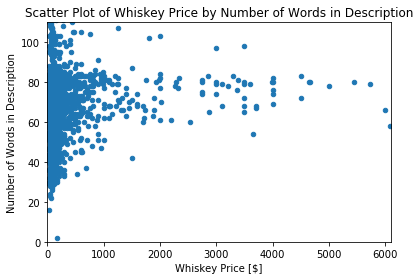

In [114]:
dfmodel.plot.scatter('Wprice','d_len') # the color and size of each point can also be defined

plt.xlabel('Whiskey Price [$]')
plt.ylabel('Number of Words in Description')
plt.title('Scatter Plot of Whiskey Price by Number of Words in Description')
plt.xlim(0,6100)
plt.ylim(0,110)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/scatter_dlen_price.png',dpi=300)
plt.show()

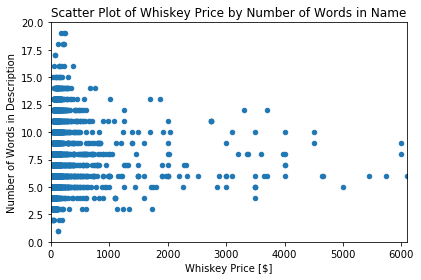

In [115]:
dfmodel.plot.scatter('Wprice','n_len') # the color and size of each point can also be defined

plt.xlabel('Whiskey Price [$]')
plt.ylabel('Number of Words in Description')
plt.title('Scatter Plot of Whiskey Price by Number of Words in Name')
plt.xlim(0,6100)
plt.ylim(0,20)
plt.tight_layout()
plt.savefig(dirname(d)+'/Figures/scatter_dlen_price.png',dpi=300)
plt.show()

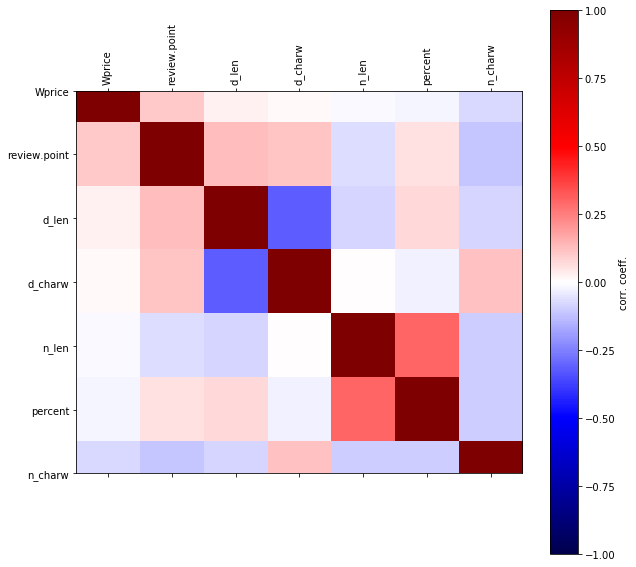

In [116]:
corrmat = dfmodel.corr()

all_cols = corrmat.sort_values('Wprice',ascending=False)['Wprice'].index 
cols = all_cols[:10] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.savefig(dirname(d)+'/Figures/newcorrelation.png',dpi=300)
#plt.tight_layout()
plt.show()

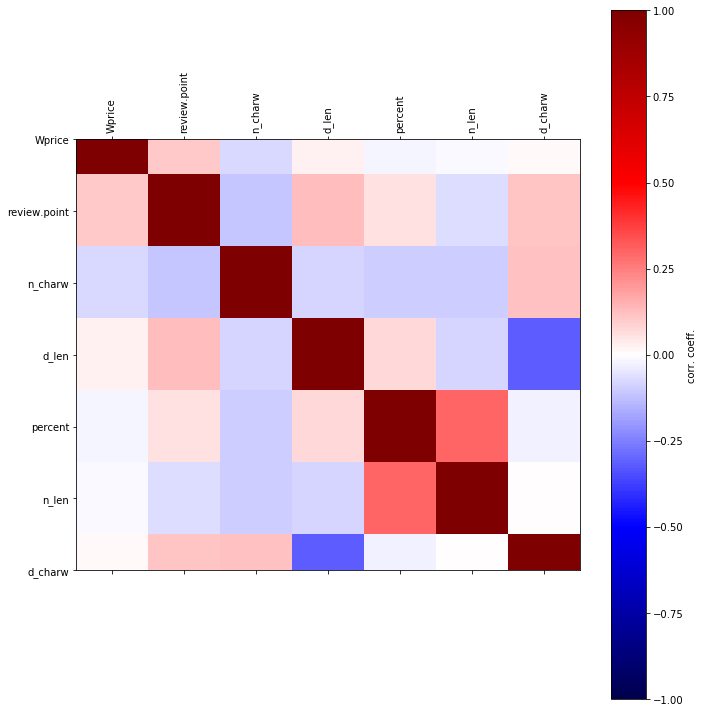

In [117]:
corrmat = dfmodel.corr()

# use the absolute value of the correlation matrix for sorting!
all_cols = np.abs(corrmat).sort_values('Wprice',ascending=False)['Wprice'].index 
cols = all_cols[:25] # positively correlated features

cm = corrmat.loc[cols,cols]

plt.figure(figsize=(10,10))
plt.matshow(cm,vmin=-1,vmax=1,cmap='seismic',fignum=0)
plt.colorbar(label='corr. coeff.')
plt.xticks(np.arange(cm.shape[0]),list(cols),rotation=90)
plt.yticks(np.arange(cm.shape[0]),list(cols))
plt.tight_layout()
#plt.savefig('figures/abs_corr_coeff_dummies.png',dpi=300)
plt.show()